In [32]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

BALANCE_CLASSES = False

GC_CONTENT_WINDOW_SIZE = 1000000

## Compute SNV scores and GC content of a set of positive and negative genes (i.e. genes that are known to be under negative selection or no selection) by using ONLY the exons of these genes


In [33]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" 
    f" -b <(tail -n +2 {b_filename})"
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)
  b_file_header = get_header(b_filename)

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include exons that don't overlap any Chen windows
  df = df[df['chen_chrom'] != '.'] 

  # having removed records where 'chen_score' is '.', we can now convert the column to a float
  # having removed records where 'corrected_chen_score' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'chen_score': float,
      'corrected_chen_score': float,
      'window_GC_content': float,
    }
  )

  return df 
  
def assign_scores_to_labeled_genes(gene_class):
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.{gene_class}.sorted.bed'

  chen_data_directory = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
  chen_file_stem = f'Supplementary_Data_2' # chen scores for 1kb windows
  b_filename = f'{chen_data_directory}/{chen_file_stem}.GC_content_{GC_CONTENT_WINDOW_SIZE}.corrected.bed'  

  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{gene_class}-canonical-exons-intersect-chen-windows.corrected.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['exon_chen_overlap'],
  )

  df = df[
    (df['chromosome'] != 'chrX') &
    (df['chromosome'] != 'chrY')
  ]

  df = make_scores_numeric(df)
  
  # though unlikely, some exons may intersect multiple Chen windows, 
  # so let's group by exon, and aggregare scores over all Chen windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'chen_score': [np.max],
      'corrected_chen_score': [np.max],
      'window_GC_content': [np.mean]
    }
  )

  # group exons by parent gene, aggregating scores in each group
  df = aggregate(
    df, 
    group_columns = ['gene_symbol'],
    aggregation_functions = {
      'max chen_score': [np.max],
      'max corrected_chen_score': [np.max],
      'mean window_GC_content': [np.mean]
    }
  )

  df = df.rename(columns={
    'max max chen_score': 'max chen_score over all exons',
    'max max corrected_chen_score': 'max corrected_chen_score over all exons',
    'mean mean window_GC_content': 'mean window_GC_content over all exons',
  })

  return df 

assign_scores_to_labeled_genes(gene_class='negative')

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/negative-canonical-exons-intersect-chen-windows.corrected.bed
<ipython-input-33-0db09e150d80>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,gene_symbol,max chen_score over all exons,max corrected_chen_score over all exons,mean window_GC_content over all exons
0,OR10A3,0.817755,0.037319,0.438472
1,OR10A4,-1.320257,-0.786916,0.407278
2,OR10A5,0.349816,0.118358,0.409221
3,OR10A6,-1.652275,-1.342695,0.439388
4,OR10AD1,-0.050568,-0.473821,0.441041
...,...,...,...,...
291,OR9G4,-3.281551,-1.570297,0.380730
292,OR9I1,-0.853197,-0.460261,0.401501
293,OR9K2,-3.569851,-1.725718,0.380290
294,OR9Q1,0.223640,0.056965,0.409494


## Combine SNV scores of positive and negative genes 


In [34]:
def create_examples(gene_class): 
  df = assign_scores_to_labeled_genes(gene_class)
  df['truly constrained'] = gene_class == 'positive'
  return df

def concat(dfs): 
  df = pd.concat(dfs)
  df = df.reset_index(drop=True) # drop duplicates in index so that later index-based operations are possible 
  return df

def label_examples(): 
  negative_examples = create_examples(gene_class='negative')
  positive_examples = create_examples(gene_class='positive')

  if BALANCE_CLASSES: # balance classes for later training 
    positive_examples = positive_examples.sample(n=len(negative_examples), random_state=0) 

  df = concat([negative_examples, positive_examples])

  return df 

LABELED_EXAMPLES = label_examples()
LABELED_EXAMPLES

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/negative-canonical-exons-intersect-chen-windows.corrected.bed
<ipython-input-33-0db09e150d80>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/positive-canonical-exons-intersect-chen-windows.corrected.bed


,gene_symbol,max chen_score over all exons,max corrected_chen_score over all exons,mean window_GC_content over all exons,truly constrained
0,OR10A3,0.817755,0.037319,0.438472,False
1,OR10A4,-1.320257,-0.786916,0.407278,False
2,OR10A5,0.349816,0.118358,0.409221,False
3,OR10A6,-1.652275,-1.342695,0.439388,False
4,OR10AD1,-0.050568,-0.473821,0.441041,False
...,...,...,...,...,...
966,ZFPM2,1.773814,1.419821,0.364265,True
967,ZFYVE27,3.042094,0.927445,0.467800,True
968,ZIC2,6.324925,3.295943,0.421137,True
969,ZMYND11,5.563482,2.600328,0.449526,True


## Plot the distribution of scores of positive and negative genes

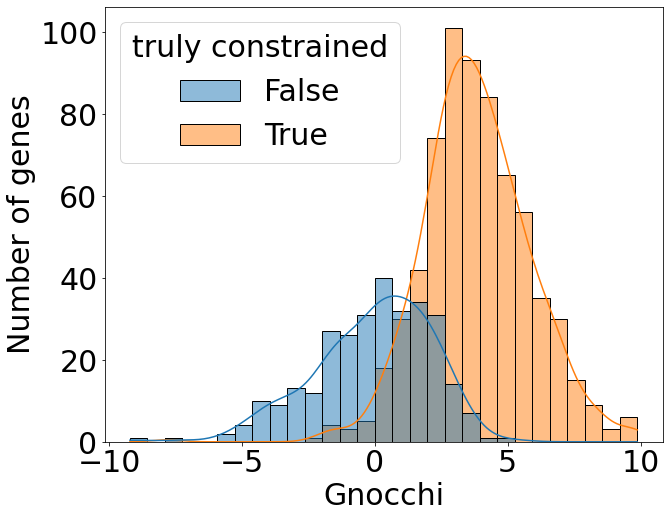

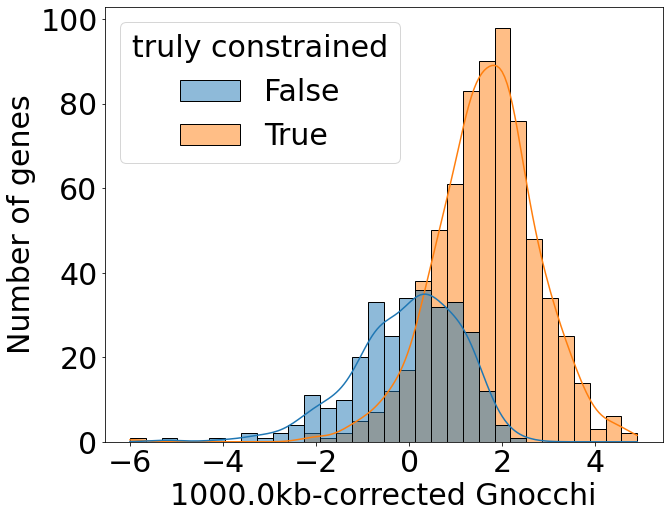

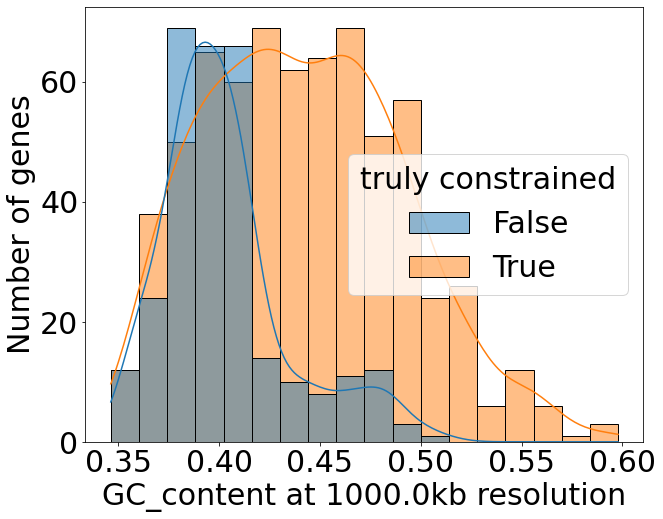

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (10, 8)

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='max chen_score over all exons', hue='truly constrained', kde=True)
plt.xlabel('Gnocchi')
plt.ylabel('Number of genes')
# plt.xlim(-10, 10)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='max corrected_chen_score over all exons', hue='truly constrained', kde=True)
plt.xlabel(f'{GC_CONTENT_WINDOW_SIZE/1e3}kb-corrected Gnocchi')
plt.ylabel('Number of genes')
# plt.xlim(-10, 10)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='mean window_GC_content over all exons', hue='truly constrained', kde=True)
plt.xlabel(f'GC_content at {GC_CONTENT_WINDOW_SIZE/1e3}kb resolution')
plt.ylabel('Number of genes')
# plt.xlim(-10, 10)
plt.show()

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

def predict_constraint(df, features, prob_threshold): 
  X = df[features]
  y = df['truly constrained']

  # model = LinearDiscriminantAnalysis()
  # model = QuadraticDiscriminantAnalysis()
  model = LogisticRegression() 

  model.fit(X, y)

  df['predicted to be constrained'] = model.predict_proba(X)[:, 1] > prob_threshold

  return df 

# original-gnocchi classifier 
predict_constraint(
  LABELED_EXAMPLES, 
  features=['max chen_score over all exons'], 
  prob_threshold=0.7
)

,gene_symbol,max chen_score over all exons,max corrected_chen_score over all exons,mean window_GC_content over all exons,truly constrained,predicted to be constrained
0,OR10A3,0.817755,0.037319,0.438472,False,False
1,OR10A4,-1.320257,-0.786916,0.407278,False,False
2,OR10A5,0.349816,0.118358,0.409221,False,False
3,OR10A6,-1.652275,-1.342695,0.439388,False,False
4,OR10AD1,-0.050568,-0.473821,0.441041,False,False
...,...,...,...,...,...,...
966,ZFPM2,1.773814,1.419821,0.364265,True,False
967,ZFYVE27,3.042094,0.927445,0.467800,True,True
968,ZIC2,6.324925,3.295943,0.421137,True,True
969,ZMYND11,5.563482,2.600328,0.449526,True,True


In [37]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['truly constrained']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def predict_and_compute_precision_recall(df, features, prob_threshold, log=False): 
  if log: print(prob_threshold)
  df = predict_constraint(df, features, prob_threshold)
  precision, recall = compute_precision_recall(df, log)
  return precision, recall
  
predict_and_compute_precision_recall(
  LABELED_EXAMPLES, 
  features=['max chen_score over all exons'], 
  prob_threshold=0.7
)

(0.917741935483871, 0.8429629629629629)

In [38]:
def plot_precision_recall(df, features, prob_thresholds, color, linestyle, log=False): 
  precision_recall = [
    predict_and_compute_precision_recall(df, features, prob_threshold, log=log)
    for prob_threshold in prob_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label=f'using {features}', color=color, linestyle=linestyle, marker='o', markersize=5)

## Naive classifier 

In [39]:
def predict_and_compute_precision_recall_under_naive_classifier(df, score, score_threshold):
  df['predicted to be constrained'] = df[score] > score_threshold
  TP = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == True)].shape[0]
  FP = df[(df['truly constrained'] == False) & (df['predicted to be constrained'] == True)].shape[0]
  FN = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == False)].shape[0]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  return precision, recall

In [40]:
def plot_precision_recall_under_naive_classifier(df, score, score_thresholds, color, linestyle): 
  precision_recall = [
    predict_and_compute_precision_recall_under_naive_classifier(
      df, 
      score, 
      score_threshold
    )
    for score_threshold in score_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(
    recalls, 
    precisions, 
    label=f'naive SV (thresholding "{score}")', 
    color=color,
    linestyle=linestyle,
    marker='o',
    markersize=5
  )

## Baseline classifier

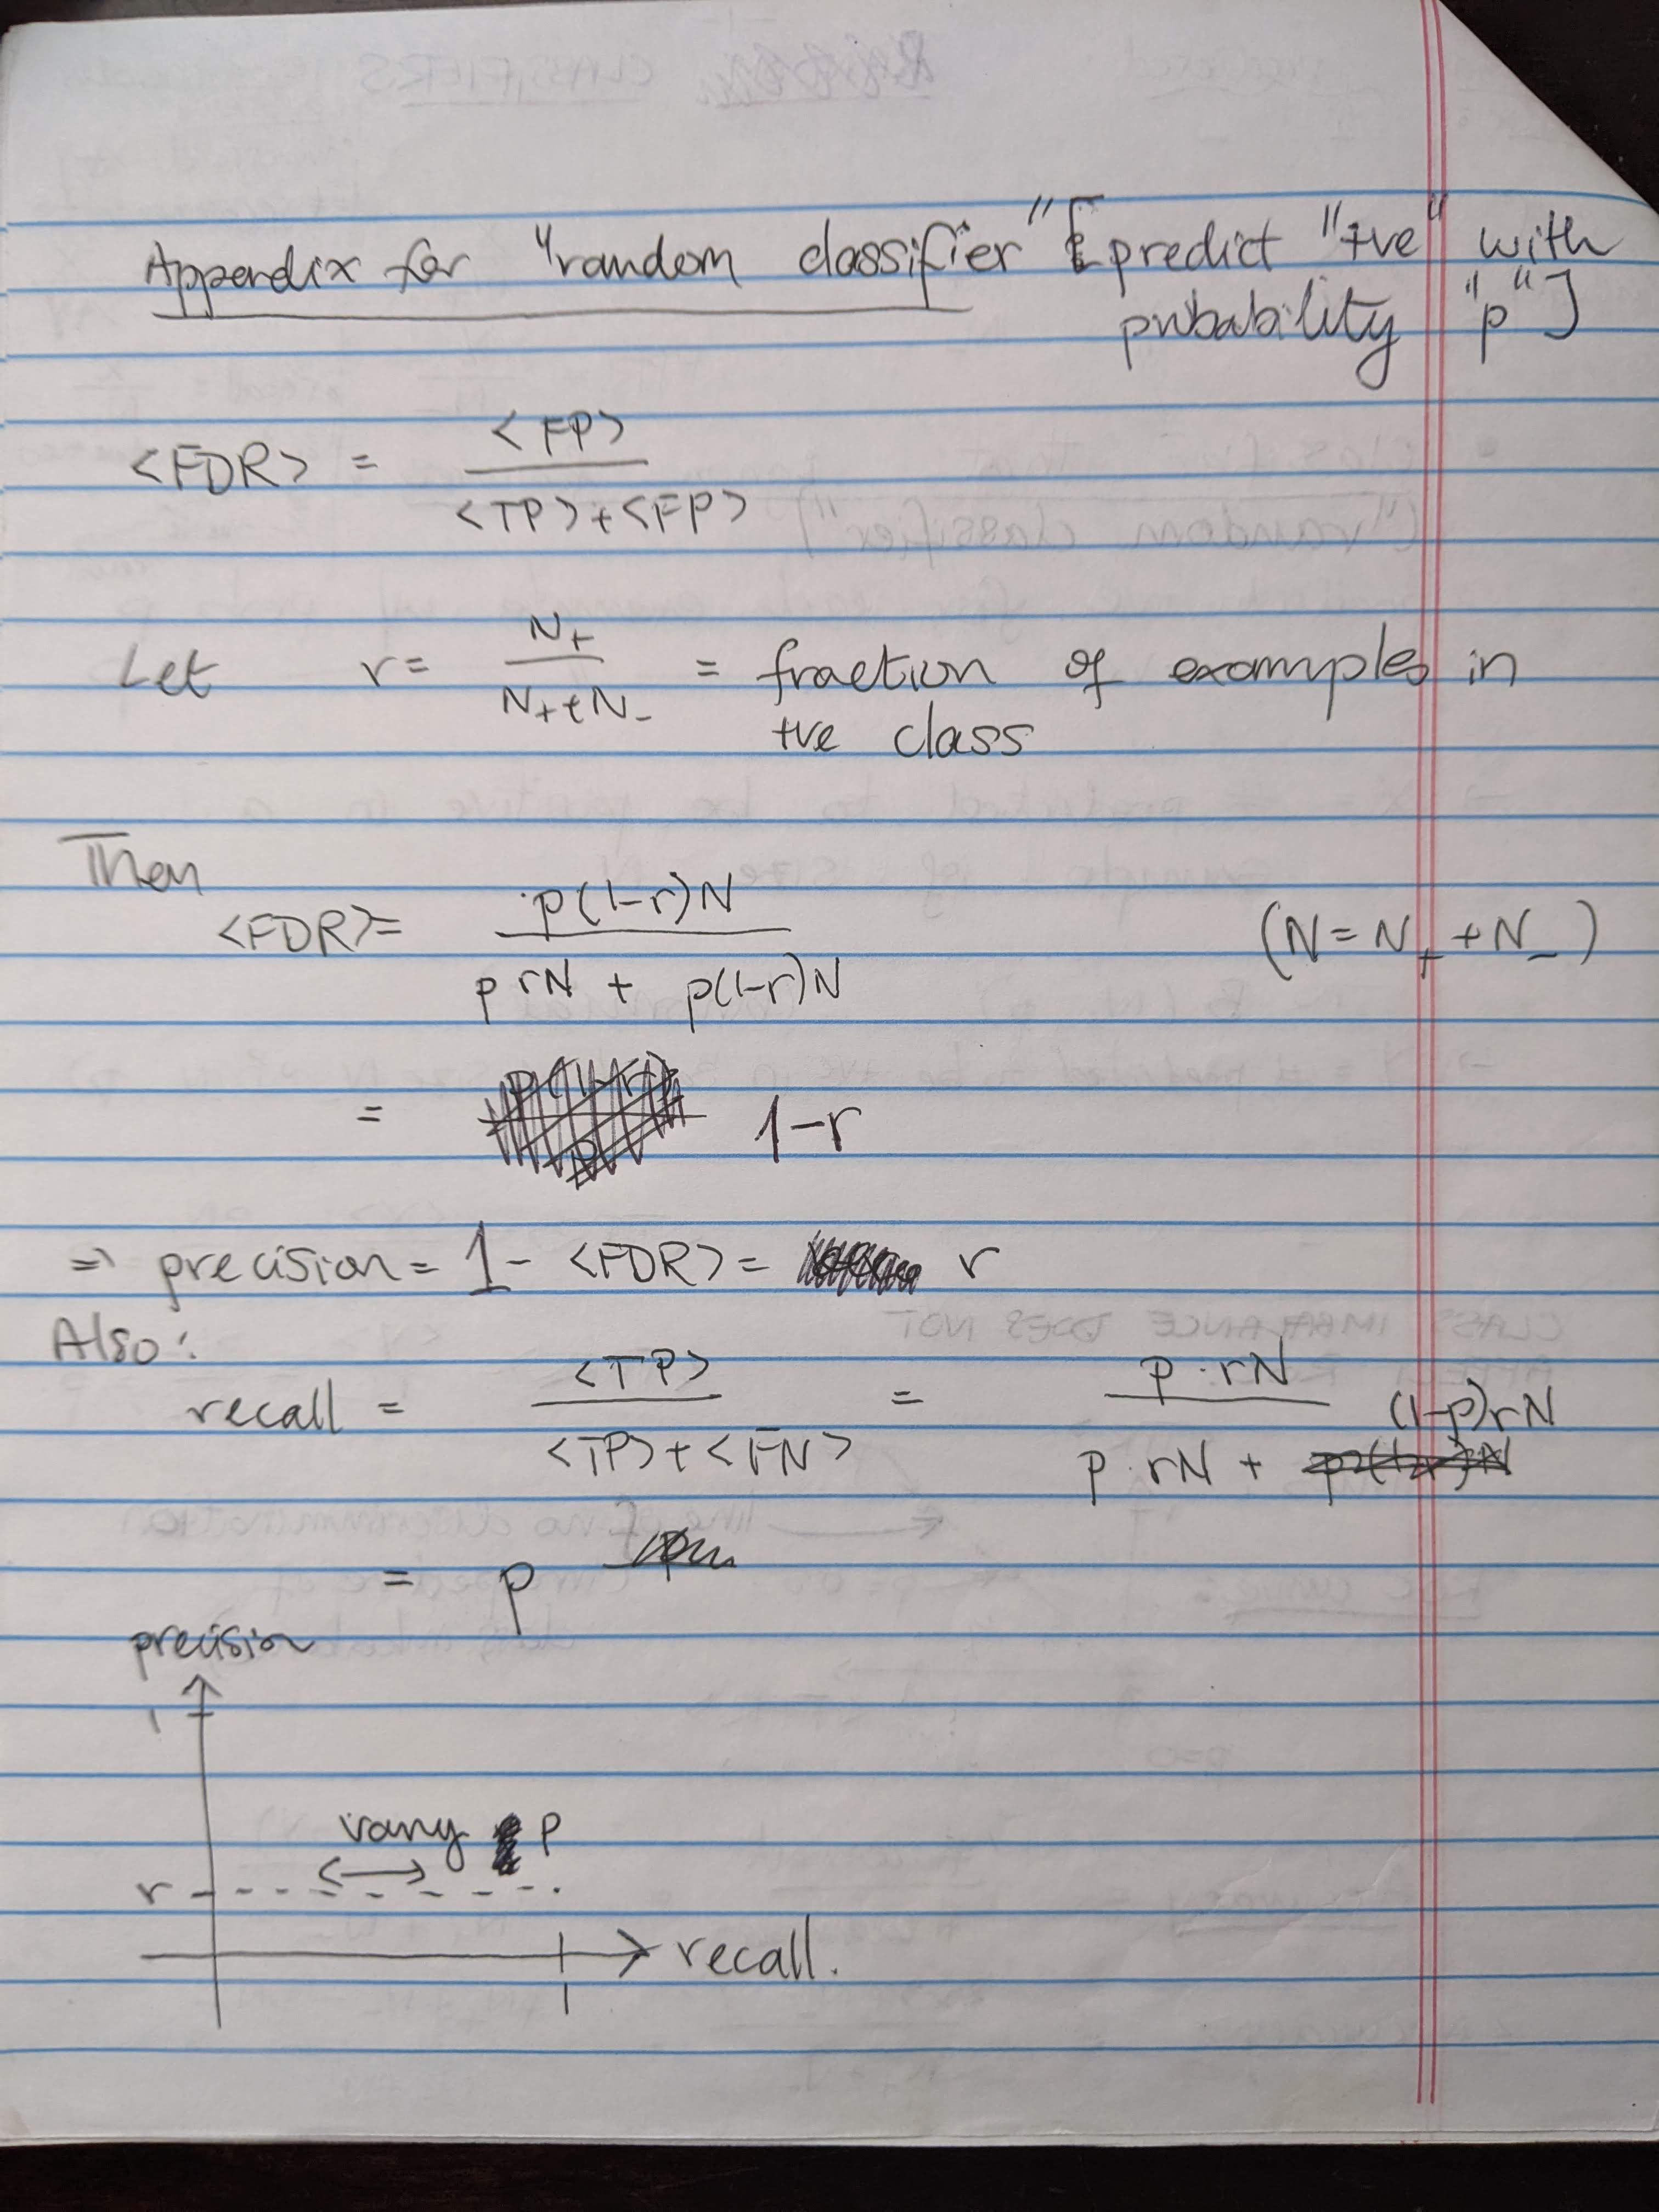

In [41]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Compare all classifiers in one PR plot

In [42]:
def compute_positive_fraction(df):
  # this is "r" in the baseline-classifier theory 
  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

compute_positive_fraction(LABELED_EXAMPLES)

0.6951596292481977

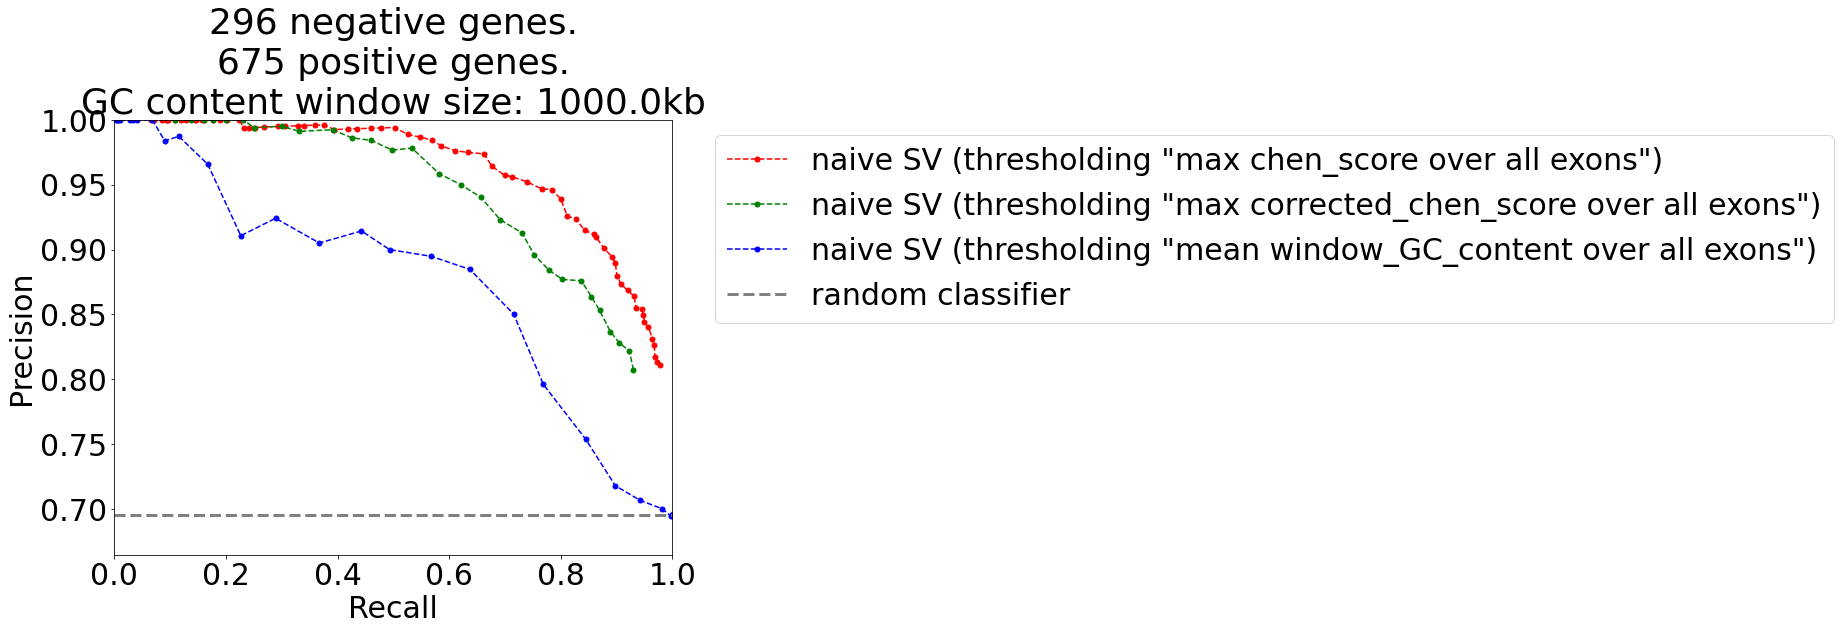

In [43]:
def plot_precision_recall_for_all_classifiers(df): 
  # plot_precision_recall(
  #   df, 
  #   features=['max chen_score over all exons'], 
  #   prob_thresholds=np.arange(0.02, 0.98, 0.02),
  #   color='red',
  #   linestyle='-'
  # )
  # plot_precision_recall(
  #   df, 
  #   features=['max corrected_chen_score over all exons'], 
  #   prob_thresholds=np.arange(0.02, 0.98, 0.02),
  #   color='green',
  #   linestyle='-'
  # )

  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='max chen_score over all exons',
    score_thresholds=np.arange(0.1, 7, 0.1),
    color='red',
    linestyle='--'
  )  
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='max corrected_chen_score over all exons',
    score_thresholds=np.arange(0.1, 3, 0.1),
    color='green',
    linestyle='--'
  )
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='mean window_GC_content over all exons',
    score_thresholds=np.arange(0.30, 0.60, 0.01),
    color='blue',
    linestyle='--',
  )

  # random classifier
  r = compute_positive_fraction(df)
  plt.plot([0, 1], [r, r], linestyle='--', linewidth=3, color='grey', label='random classifier')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xlim(0, 1)
  plt.ylim(r - (1-r)*0.1, 1)

  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  plt.title(
    f'{number_negative_examples} negative genes.\n'
    f'{number_positive_examples} positive genes.\n'
    f'GC content window size: {GC_CONTENT_WINDOW_SIZE/1e3}kb'
  )
  
plot_precision_recall_for_all_classifiers(LABELED_EXAMPLES)

## [OPT] Other performance metrics and truth sets

In [45]:
# 1. intersect chen windows with canonical-exons.sorted.bed.gz; assign these chen windows a "constrained=True" label
# 2. subtract chen windows from canonical-exons.sorted.bed.gz; downsample; assign these chen windows a "constrained=False" label


In [46]:
# this notebook has exon-overlap status for chen windows: experiments/germline-model/chen-et-al-2022/deletion-density.1.ipynb 
# predict constrained enhancers using: experiments/germline-model/chen-et-al-2022/SNV_plus_SV_model.4.ipynb

# 0. review presentations to see what other truth sets, and validation metrics I've used in the past 

# 2. does corrected gnocchi better separate the coding and noncoding score distributions than the original gnocchi?
# 3. does corrected gnocchi better separate the constrained and unconstrained enhancers than the original gnocchi? experiments/germline-model/chen-et-al-2022/SNV_plus_SV_model.4.ipynb

# 0. compute an expected SNV count using corrected z-scores, and compare to observed SNV count (scatter plot), and demonstrate that R2 is higher than using original z-scores
# 1. create a UCSC track for the expected SNV count using corrected z-scores, and compare to observed SNV count, just like Mural did for their model 
# 1. do QQ-plots for the corrected gnocchi scores look better than the original?
# 2. is ROC for noncoding pathogenic variants better using corrected gnocchi scores, vs original gnocchi scores?
